In [1]:
import numpy as np
import matplotlib.pyplot as plt


class NeuronWithSelfConnection:
    def __init__(self, w=0.05, I=-3, noise_strength=0):
        self.w = w                  # Synaptic strength
        self.I = I                  # External input
        self.noise_strength = noise_strength  # Noise magnitude
        
    def activation_function(self, s):
        """Sigmoid activation function: f(s) = 60(1 + tanh(s))"""
        return 60 * (1 + np.tanh(s))
    
    def derivative(self, r):
        """Calculate dr/dt for the neuron"""
        total_input = self.w * r + self.I
        return -r + self.activation_function(total_input)
    
    def simulate(self, r0, t_max, dt=0.1):
        """Simulate the neuron dynamics"""
        steps = int(t_max / dt)
        t = np.linspace(0, t_max, steps)
        r = np.zeros(steps)
        r[0] = r0
        
        for i in range(1, steps):
            noise = self.noise_strength * np.random.normal(0, 1) * np.sqrt(dt)
            dr = self.derivative(r[i-1]) * dt + noise
            r[i] = r[i-1] + dr
            
        return t, r
    
    def find_fixed_points(self, r_range):
        """Find fixed points where dr/dt = 0"""
        def flux(r):
            return self.derivative(r)
        
        # Find potential fixed points by looking for sign changes in the flux
        r_values = np.linspace(r_range[0], r_range[1], 1000)
        flux_values = np.array([flux(r) for r in r_values])
        
        # Identify where flux changes sign (potential fixed points)
        sign_changes = np.where(np.diff(np.signbit(flux_values)))[0]
        fixed_points = []
        
        # Refine each potential fixed point using bisection method
        for idx in sign_changes:
            r_left = r_values[idx]
            r_right = r_values[idx + 1]
            flux_left = flux_values[idx]
            flux_right = flux_values[idx + 1]
            
            # Bisection method to refine the fixed point
            tolerance = 1e-10
            max_iterations = 100
            
            for _ in range(max_iterations):
                r_mid = (r_left + r_right) / 2
                flux_mid = flux(r_mid)
                
                if abs(flux_mid) < tolerance:
                    # Found a fixed point
                    if all(abs(r_mid - fp) > 1e-6 for fp in fixed_points):
                        fixed_points.append(r_mid)
                        break
                
                if flux_mid * flux_left < 0:
                    r_right = r_mid
                    flux_right = flux_mid
                else:
                    r_left = r_mid
                    flux_left = flux_mid
                
                if (r_right - r_left) < tolerance:
                    # Interval is small enough, add the midpoint as a fixed point
                    if all(abs(r_mid - fp) > 1e-6 for fp in fixed_points):
                        fixed_points.append(r_mid)
                        break
        
        return np.array(fixed_points)

    def plot_activation_function(self, s_range=(-10, 10)):
        """Plot the activation function f(s)"""
        s = np.linspace(s_range[0], s_range[1], 1000)
        f_s = self.activation_function(s)
        
        plt.figure(figsize=(10, 6))
        plt.plot(s, f_s)
        plt.grid(True)
        plt.xlabel('Input (s)')
        plt.ylabel('Activation f(s)')
        plt.title('Neuron Activation Function')
        plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
        plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
        # plt.savefig('./latex/activation_function.png')
        plt.show()
    
    def plot_dynamics(self, r0_list, t_max, dt=0.1):
        """Plot the dynamics for multiple initial conditions"""
        plt.figure(figsize=(10, 6))
        
        for r0 in r0_list:
            t, r = self.simulate(r0, t_max, dt)
            plt.plot(t, r, label=f'r(0) = {r0}')
            
        plt.grid(True)
        plt.xlabel('Time')
        plt.ylabel('Firing rate r(t)')
        plt.title('Neuron Dynamics')
        plt.legend()
        # plt.savefig('./latex/deterministic_dynamics.png')
        plt.show()
    
    def plot_flux(self, r_range=(0, 120)):
        """Plot the flux function dr/dt vs r"""
        r_values = np.linspace(r_range[0], r_range[1], 1000)
        flux_values = np.array([self.derivative(r) for r in r_values])
        
        # Find fixed points
        fixed_points = self.find_fixed_points(r_range)
        
        plt.figure(figsize=(10, 6))
        plt.plot(r_values, flux_values)
        plt.grid(True)
        plt.xlabel('Firing rate (r)')
        plt.ylabel('dr/dt')
        plt.title('Flux: dr/dt vs r')
        
        # Plot fixed points
        plt.scatter(fixed_points, np.zeros_like(fixed_points), 
                    color='red', s=100, zorder=5, label='Fixed Points')
        
        plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
        plt.legend()
        # plt.savefig('./latex/flux_analysis.png')
        plt.show()
        
        return fixed_points
        
    def create_bifurcation_diagram(self, w_range=(0, 1), I_range=(-5, 0), 
                                 w_steps=100, I_steps=100):
        """Create a bifurcation diagram showing number of fixed points"""
        w_values = np.linspace(w_range[0], w_range[1], w_steps)
        I_values = np.linspace(I_range[0], I_range[1], I_steps)
        
        # Initialize matrix to store number of solutions
        solution_matrix = np.zeros((I_steps, w_steps))
        
        # Calculate number of solutions for each (w, I) pair
        for i, I in enumerate(I_values):
            for j, w in enumerate(w_values):
                # Update parameters
                self.w = w
                self.I = I
                
                # Find fixed points
                fps = self.find_fixed_points((-500, 500))
                solution_matrix[i, j] = len(fps)
                
        # Plot the bifurcation diagram
        plt.figure(figsize=(10, 8))
        plt.imshow(solution_matrix, origin='lower', aspect='auto', 
                   extent=[w_range[0], w_range[1], I_range[0], I_range[1]])
        
        plt.colorbar(label='Number of Fixed Points')
        plt.xlabel('Synaptic Strength (w)')
        plt.ylabel('External Input (I)')
        plt.title('Bifurcation Diagram')
        # plt.savefig('./latex/bifurcation_diagram.png')
        plt.show()
        
        # Reset to original values
        self.w = 0.05
        self.I = -3
        
        return solution_matrix

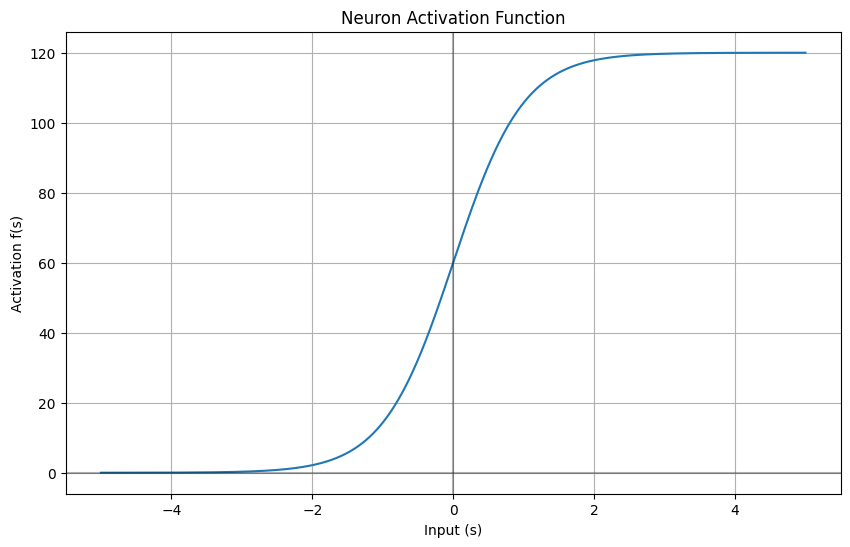

In [2]:

# Create neuron with default parameters (w=0.05, I=-3)
neuron = NeuronWithSelfConnection()

# Plot the activation function for a suitable range
neuron.plot_activation_function(s_range=(-5, 5))


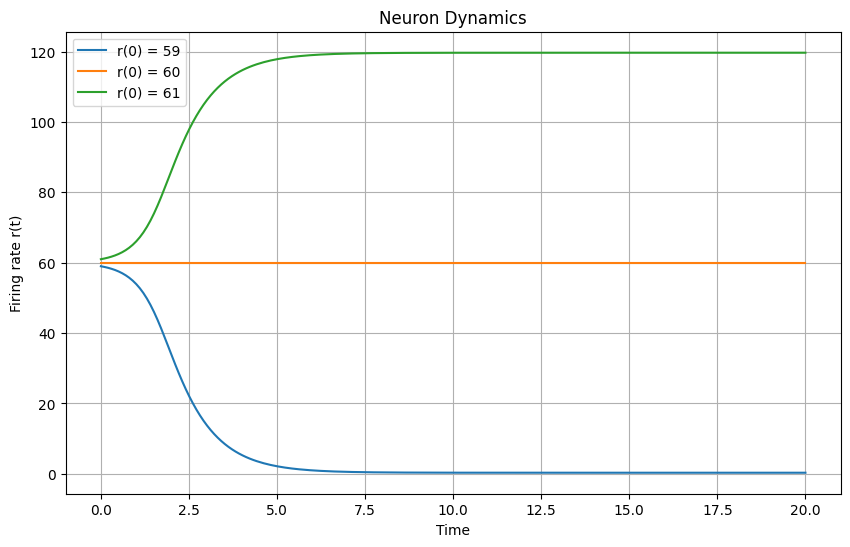

Fixed points of the system:
r = 0.305908 (stable)
r = 60.000000 (unstable)
r = 119.694092 (stable)


In [26]:


"""Solution to problem 1.2: Study the dynamics for different initial conditions"""
neuron = NeuronWithSelfConnection()

# Initial conditions to study
r0_list = [59, 60, 61]

# Plot the dynamics
neuron.plot_dynamics(r0_list, t_max=20)

# Let's also look at the fixed points to understand the dynamics
print("Fixed points of the system:")
fixed_points = neuron.find_fixed_points((0, 120))
for fp in fixed_points:
    stability = "stable" if neuron.derivative(fp + 0.1) < 0 else "unstable"
    print(f"r = {fp:.6f} ({stability})")

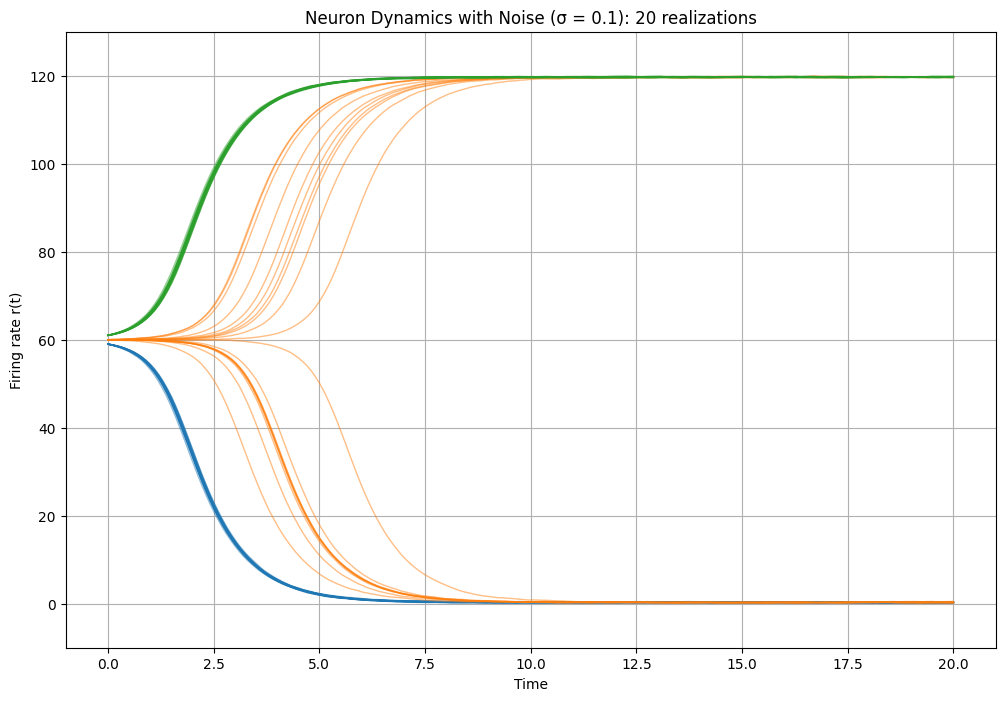

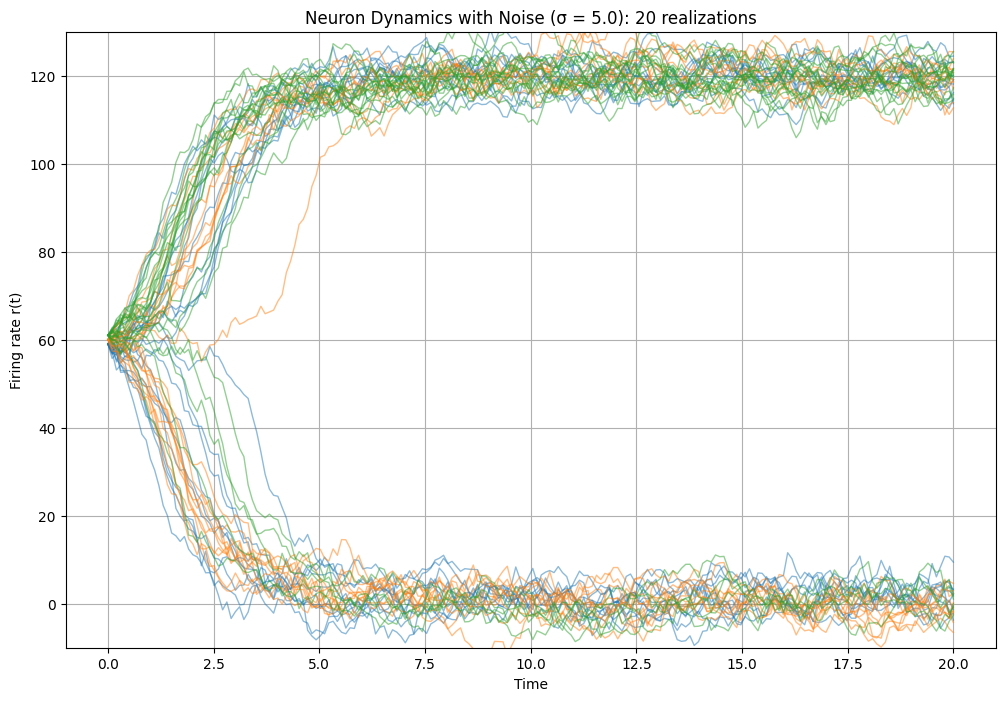

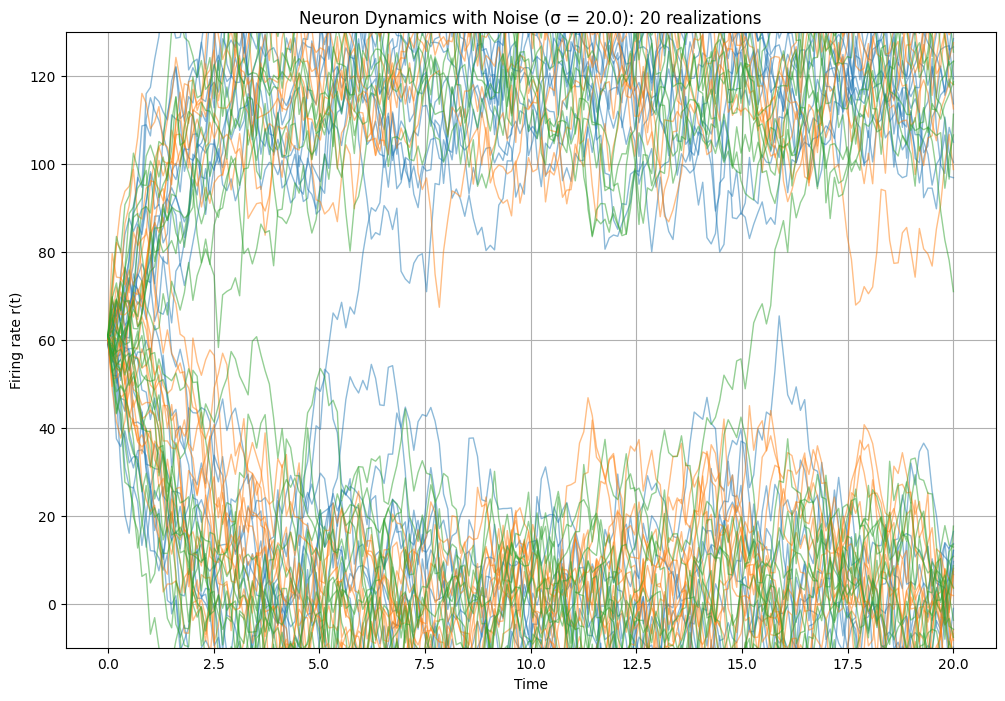

In [14]:

"""Solution to problem 1.3: Add noise and observe the consequences"""
# Create figures for different noise strengths
noise_strengths = [0.1, 5.0, 20.0]

for noise in noise_strengths:
    # Create neuron with noise
        neuron = NeuronWithSelfConnection(noise_strength=noise)
        
        # Create a figure for this noise strength
        plt.figure(figsize=(12, 8))
        
        # Choose an initial condition around the middle fixed point
        r0_list = [59,60,61]
        colors = ['C0', 'C1', 'C2']
        
        # Run 20 trajectories with the same initial condition but different noise realizations
        for j in range(3):
            for i in range(20):
                t, r = neuron.simulate(r0_list[j], t_max=20)
                plt.plot(t, r, alpha=0.5, linewidth=1, label=f'Initial condition: {r0_list[j]}', color=colors[j])
        plt.grid(True)
        plt.xlabel('Time')
        plt.ylabel('Firing rate r(t)')
        plt.title(f'Neuron Dynamics with Noise (σ = {noise}): 20 realizations')
        plt.ylim(-10, 130)  # Set y-limits to see the full range
        plt.savefig(f'./latex/noise_strength_{noise}.png')
        plt.show()




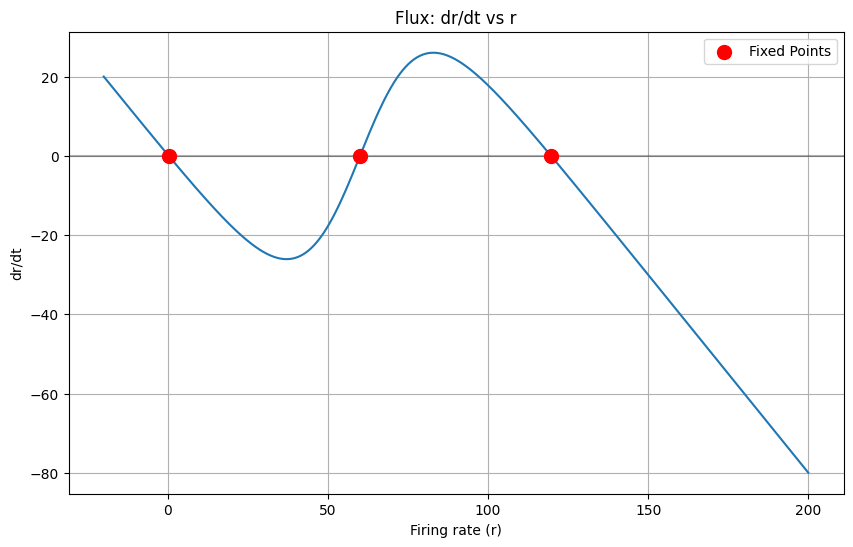

Fixed points (zero-crossings):
r = 0.305908 (stable)
r = 60.000000 (unstable)
r = 119.694092 (stable)


In [82]:


"""Solution to problem 1.4: Study the flux dr/dt vs r"""
neuron = NeuronWithSelfConnection()

# Plot the flux
fixed_points = neuron.plot_flux(r_range=(-20, 200))

# Print the fixed points
print("Fixed points (zero-crossings):")
for fp in fixed_points:
    # Determine stability based on the slope of dr/dt at the fixed point
    # If slope is negative, the fixed point is stable; if positive, unstable
    r_test = fp + 0.001
    slope = (neuron.derivative(r_test) - neuron.derivative(fp)) / 0.001
    stability = "stable" if slope < 0 else "unstable"
    print(f"r = {fp:.6f} ({stability})")

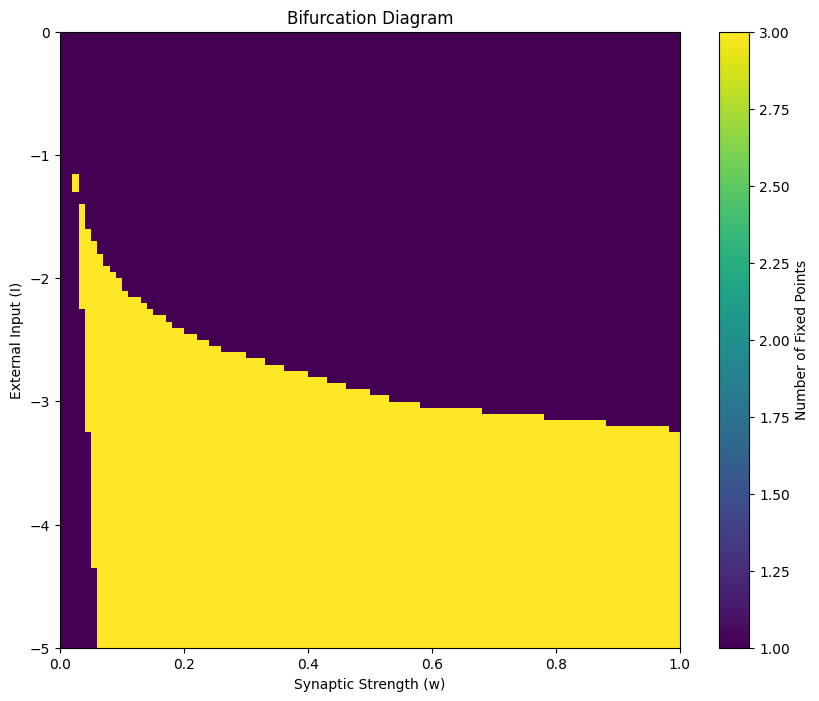

In [81]:

neuron = NeuronWithSelfConnection()

# Create the bifurcation diagram
solution_matrix = neuron.create_bifurcation_diagram(
    w_range=(0, 1), 
    I_range=(-5, 0), 
    w_steps=100, 
    I_steps=100
)



Analysis of specific parameter values:


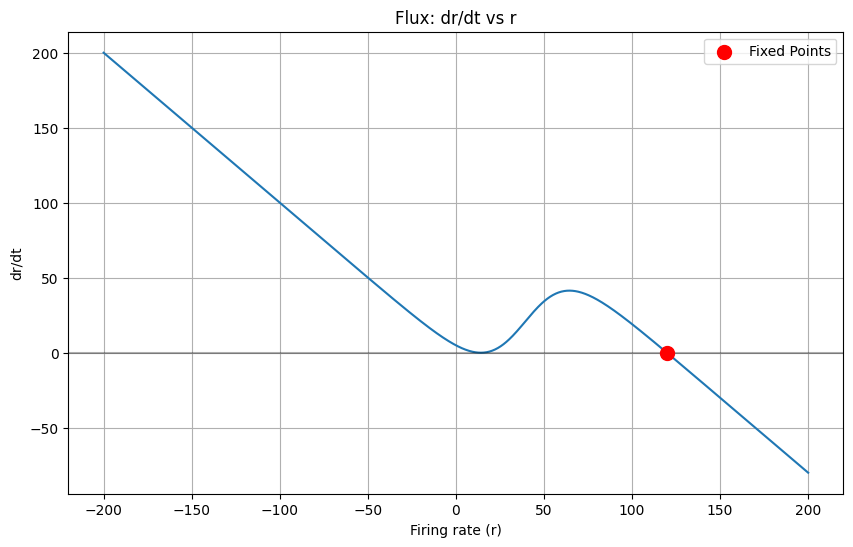


w = 0.04, I = -1.5721552
Number of fixed points: 1
  r = 119.808812


In [80]:
# For additional analysis, we can check specific values
print("Analysis of specific parameter values:")

test_cases = [
    # (0.05, -3),  # Our original parameters
    # (0.5, -3),   # Higher synaptic strength
    # (0.05, -1),   # Higher external input
    # (0.6, -4),  # Higher external input
    (4 * 0.01, -31 * 0.05 - 0.0221552),  # Higher synaptic strength

]

for w, I in test_cases:
    neuron.w = w
    neuron.I = I
    fixed_points = neuron.find_fixed_points((-200, 200))
    neuron.plot_flux(r_range=(-200, 200))
    print(f"\nw = {w}, I = {I}")
    print(f"Number of fixed points: {len(fixed_points)}")
    for fp in fixed_points:
        print(f"  r = {fp:.6f}")


In [34]:
print(solution_matrix)

[[1. 1. 1. ... 3. 3. 3.]
 [1. 1. 1. ... 3. 3. 3.]
 [1. 1. 1. ... 3. 3. 3.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
